In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from sklearn.model_selection import KFold
import tflite_helper
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil

In [3]:
# Load data from CSV files
def load_data(file_path, label):
    df = pd.read_csv(file_path)
    data = df.iloc[:, :].values  # Exclude header and assume data starts from the second column
    labels = [label] * len(data)
    return data, labels

# Load the data for all classes
data1, labels1 = load_data("data/rock2.csv", "rock")
data2, labels2 = load_data("data/paper2.csv", "paper")
data3, labels3 = load_data("data/scissors2.csv", "scissors")
data4, labels4 = load_data("data/rock.csv", "rock")
data5, labels5 = load_data("data/paper.csv", "paper")
data6, labels6 = load_data("data/scissors.csv", "scissors")
data7, labels7 = load_data("data/rock3.csv", "rock")
data8, labels8 = load_data("data/paper3.csv", "paper")
data9, labels9 = load_data("data/scissors3.csv", "scissors")

# Combine the data and labels
data = np.vstack([data1, data2, data3, data4, data5, data6, data7, data8, data9])
labels = np.array(labels1 + labels2 + labels3 + labels4 + labels5 + labels6 + labels7 +labels8 + labels9)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize data (assuming pixel values are integers)
data = data / 400.0

# Reshape data to 8x8 images
data = data.reshape(-1, 8, 8, 1)  # Add channel dimension

In [4]:
# Data augmentation
data_augmented = []
labels_augmented = []

for image, label in zip(data, labels_encoded):
    data_augmented.append(image)  # Original
    labels_augmented.append(label)

    # Flip horizontally
    flipped_h = np.flip(image, axis=1)
    data_augmented.append(flipped_h)
    labels_augmented.append(label)

    # Flip vertically
    flipped_v = np.flip(image, axis=0)
    data_augmented.append(flipped_v)
    labels_augmented.append(label)

    # Add random noise
    noise = np.random.normal(0, 0.1, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    data_augmented.append(noisy_image)
    labels_augmented.append(label)

    # Add random noise
    noise = np.random.normal(-0.1, 0, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    data_augmented.append(noisy_image)
    labels_augmented.append(label)

    # Rotate 90 degrees
    rotated_90 = np.rot90(image, k=1)
    data_augmented.append(rotated_90)
    labels_augmented.append(label)

    # Rotate 180 degrees
    rotated_180 = np.rot90(image, k=2)
    data_augmented.append(rotated_180)
    labels_augmented.append(label)

    # Rotate 270 degrees
    rotated_270 = np.rot90(image, k=3)
    data_augmented.append(rotated_270)
    labels_augmented.append(label)

# Convert augmented data to numpy arrays
data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)


# Convert labels to one-hot encoding
labels_augmented = tf.keras.utils.to_categorical(labels_augmented, num_classes=3)

print("paper: ", len(labels_augmented[labels_augmented[:, 0] == 1]))
print("rock: ", len(labels_augmented[labels_augmented[:, 1] == 1]))
print("scissors: ", len(labels_augmented[labels_augmented[:, 2] == 1]))

paper:  1672
rock:  1688
scissors:  1704


In [5]:
data_augmented = np.reshape(data_augmented, (data_augmented.shape[0], 64))

In [6]:
def create_model():
    # Build a larger CNN model
    model = models.Sequential([
        layers.Reshape((8,8,1), input_shape=(64,)),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(8, 8, 1)),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', 
			tf.keras.metrics.Precision(name='precision'),
			tf.keras.metrics.Recall(name='recall')])
    
    return model

# K-fold Cross Validation model evaluation
kfold = KFold(n_splits=10, shuffle=True)
results = []
for train, test in tqdm(kfold.split(data_augmented, labels_augmented), total = 10):
    # Define early stopping callback to monitor validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=4)

    # Split the augmented data into training and testing sets
    X_train, y_train, X_test, y_test = data_augmented[train], labels_augmented[train], data_augmented[test], labels_augmented[test]

    model = create_model()

    # Train the model
    history = model.fit(X_train, y_train, epochs=35, batch_size=8, validation_split=0.1, callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    metrics = model.evaluate(X_test, y_test, return_dict=True)
    print(metrics)
    
    
    tflite_model = tflite_helper.convert_tflite_model(model)
    
    accuracy,precision,recall = tflite_helper.test_tflite(tflite_model, X_test, y_test)
    print('tflite: acc={:f}, prec={:f}, reca={:f}'.format(accuracy,sum(precision)/len(precision),sum(recall)/len(recall)))

    result = {
        'metrics': metrics,
        'tflite_metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall
        }
    }
    results.append(result)

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6919 - loss: 0.6668 - precision: 0.7567 - recall: 0.5925  
{'accuracy': 0.6844181418418884, 'loss': 0.7148762941360474, 'precision': 0.7639594078063965, 'recall': 0.5936883687973022}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpydi39gor\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpydi39gor\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmpydi39gor'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2639936928960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639937340688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639937345264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639937342272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639937346496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639937344208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639937348080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639937344384: TensorSpec(shape=(), dtype=tf.resource, name=None)


 10%|█         | 1/10 [00:09<01:28,  9.88s/it]

TensorFlow Lite model:
tflite: acc=0.684418, prec=0.682853, reca=0.691427


c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7766 - loss: 0.5861 - precision: 0.8197 - recall: 0.7124  
{'accuracy': 0.6883628964424133, 'loss': 0.7371588945388794, 'precision': 0.741706132888794, 'recall': 0.6173570156097412}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmp3ifnth3d\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmp3ifnth3d\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmp3ifnth3d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2639988386352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639988377552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639988388288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639988385648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639988382480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639988380896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639988390928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639988382128: TensorSpec(shape=(), dtype=tf.resource, name=None)


 20%|██        | 2/10 [00:18<01:14,  9.27s/it]

TensorFlow Lite model:
tflite: acc=0.688363, prec=0.717688, reca=0.696091


c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7532 - loss: 0.6156 - precision: 0.7777 - recall: 0.6823  
{'accuracy': 0.6765285730361938, 'loss': 0.7622101306915283, 'precision': 0.7084282636642456, 'recall': 0.6134122014045715}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmp6t625xjx\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmp6t625xjx\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmp6t625xjx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2639942076192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639942089568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639942128160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639942124288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640999835504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639935724304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639935722368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639965306400: TensorSpec(shape=(), dtype=tf.resource, name=None)


 30%|███       | 3/10 [00:27<01:03,  9.12s/it]

TensorFlow Lite model:
tflite: acc=0.676529, prec=0.713751, reca=0.683497


c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8275 - loss: 0.4600 - precision: 0.8499 - recall: 0.7716  
{'accuracy': 0.7633135914802551, 'loss': 0.5883397459983826, 'precision': 0.7990970611572266, 'recall': 0.6982248425483704}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpvt6guumd\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpvt6guumd\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmpvt6guumd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2640065450880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066090912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640065456336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066093728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066092320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066092672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066096368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066092848: TensorSpec(shape=(), dtype=tf.resource, name=None)


 40%|████      | 4/10 [00:42<01:09, 11.57s/it]

TensorFlow Lite model:
tflite: acc=0.763314, prec=0.776465, reca=0.765560


c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8198 - loss: 0.4630 - precision: 0.8459 - recall: 0.7684  
{'accuracy': 0.7371541261672974, 'loss': 0.6230461001396179, 'precision': 0.7825112342834473, 'recall': 0.6897233128547668}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpg1siyzmw\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpg1siyzmw\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmpg1siyzmw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2640124679920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066269552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066269728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066271312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066266032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066274832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066279936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066278176: TensorSpec(shape=(), dtype=tf.resource, name=None)


 50%|█████     | 5/10 [00:57<01:02, 12.48s/it]c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.737154, prec=0.745701, reca=0.728540
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7123 - loss: 0.6595 - precision: 0.7379 - recall: 0.6577  
{'accuracy': 0.6324110627174377, 'loss': 0.812572717666626, 'precision': 0.6783216595649719, 'recall': 0.5750988125801086}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpq6j7bgu8\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpq6j7bgu8\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmpq6j7bgu8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_40')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2640142804144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640142801328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640142794816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640142901216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640142902800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640142900160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640142903856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640142900336: TensorSpec(shape=(), dtype=tf.resource, name=None)


 60%|██████    | 6/10 [01:07<00:47, 11.76s/it]

TensorFlow Lite model:
tflite: acc=0.632411, prec=0.672868, reca=0.638259


c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6599 - loss: 0.6733 - precision: 0.7599 - recall: 0.5825  
{'accuracy': 0.6541501879692078, 'loss': 0.7221444845199585, 'precision': 0.75, 'recall': 0.5750988125801086}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmp19eyv93z\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmp19eyv93z\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmp19eyv93z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_48')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2640121529968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640121543520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640121565552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640121561680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640124686784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640124687488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640146807120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640124674288: TensorSpec(shape=(), dtype=tf.resource, name=None)


 70%|███████   | 7/10 [01:16<00:32, 10.80s/it]

TensorFlow Lite model:
tflite: acc=0.654150, prec=0.652059, reca=0.654986


c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8254 - loss: 0.4372 - precision: 0.8469 - recall: 0.7953  
{'accuracy': 0.768774688243866, 'loss': 0.564710259437561, 'precision': 0.798701286315918, 'recall': 0.7292490005493164}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpgsr_my29\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpgsr_my29\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmpgsr_my29'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_56')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2640181467216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640182123808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640182126624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640182122224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640182125216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640182125568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640182129264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640182125744: TensorSpec(shape=(), dtype=tf.resource, name=None)


 80%|████████  | 8/10 [01:32<00:25, 12.52s/it]

TensorFlow Lite model:
tflite: acc=0.768775, prec=0.772129, reca=0.768369


c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8120 - loss: 0.4767 - precision: 0.8533 - recall: 0.7717  
{'accuracy': 0.752964437007904, 'loss': 0.6239014267921448, 'precision': 0.7903929948806763, 'recall': 0.7154150009155273}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpr8mbkz01\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpr8mbkz01\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmpr8mbkz01'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_64')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2640066271664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639942076368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640066268672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639942083056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639942087456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639942089392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639942075840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2639942087280: TensorSpec(shape=(), dtype=tf.resource, name=None)


 90%|█████████ | 9/10 [01:54<00:15, 15.56s/it]

TensorFlow Lite model:
tflite: acc=0.752964, prec=0.776269, reca=0.752307


c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7721 - loss: 0.5697 - precision: 0.8236 - recall: 0.7228  
{'accuracy': 0.7252964377403259, 'loss': 0.6779446005821228, 'precision': 0.7831050157546997, 'recall': 0.6778656244277954}
INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpcdsadf0y\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmpcdsadf0y\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmpcdsadf0y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_72')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2640145560880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640145549440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640145557712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640145554368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640145554544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640146800608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640145552960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640146799728: TensorSpec(shape=(), dtype=tf.resource, name=None)


100%|██████████| 10/10 [02:18<00:00, 13.87s/it]

TensorFlow Lite model:
tflite: acc=0.725296, prec=0.738175, reca=0.725193


In [34]:
accuracies = np.array([d['metrics']['accuracy'] for d in results])
precisions = np.array([d['metrics']['precision'] for d in results])
recalls = np.array([d['metrics']['recall'] for d in results])
losses = np.array([d['metrics']['loss'] for d in results])
tflite_accuracies = np.array([d['tflite_metrics']['accuracy'] for d in results])
tflite_precisions = np.array([d['tflite_metrics']['precision'] for d in results])
tflite_recalls = np.array([d['tflite_metrics']['recall'] for d in results])

# print final metrics and tflite metrics
with open('.\\training\\test_results.txt', 'w') as f:
	f.write('Average scores for tensorflow model:\n')
	f.write(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})\n')
	f.write(f'> Precision: {np.mean(precisions)} (+- {np.std(precisions)})\n')
	f.write(f'> Recall: {np.mean(recalls)} (+- {np.std(recalls)})\n')
	f.write(f'> Loss: {np.mean(losses)} (+- {np.std(losses)})\n')
	f.write('Average scores for tflite:\n')
	f.write(f'> Accuracy: {np.mean(tflite_accuracies)} (+- {np.std(tflite_accuracies)})\n')
	f.write(f'> Precision: {np.mean(tflite_precisions)} (+- {np.std(tflite_precisions)})\n')
	f.write(f'> Recall: {np.mean(tflite_recalls)} (+- {np.std(tflite_recalls)})\n')

In [41]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weight_dict = {0: np.float64(1.55), 1: np.float64(1.35), 2: np.float64(0.9)}
print(class_weight_dict)

{0: np.float64(1.55), 1: np.float64(1.35), 2: np.float64(0.9)}


c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\itsmi\anaconda3\envs\vsc\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_14 (Reshape)            │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 8)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,715 (112.17 KB)

 Trainable params: 9,571 (37.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,144 (74.79 KB)

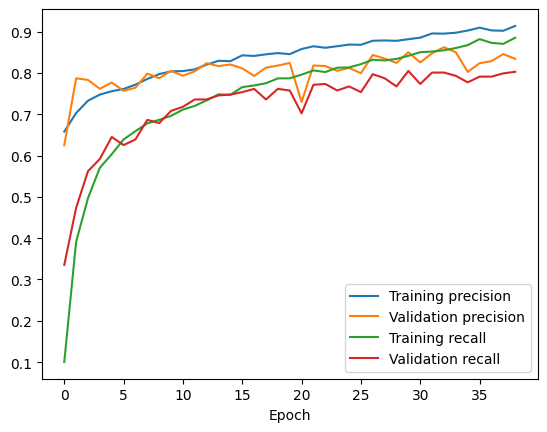

In [42]:
### Train the model on the full dataset ###
X_train, X_val, y_train, y_val = train_test_split(data_augmented, labels_augmented, test_size=0.1, random_state=42)
model = create_model()
# Define early stopping callback to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=7)
# train model
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0, 
                    class_weight=class_weight_dict 
                    )
model.summary()

# Model speichern
model.save('training/model.keras')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('training/loss_accuracy_plot.png')
plt.clf()
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('training/precision_recall_plot.png')

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
               precision    recall  f1-score   support

       paper       0.85      0.95      0.90      1672
        rock       0.86      0.89      0.88      1688
    scissors       0.96      0.81      0.88      1704

    accuracy                           0.88      5064
   macro avg       0.89      0.88      0.88      5064
weighted avg       0.89      0.88      0.88      5064



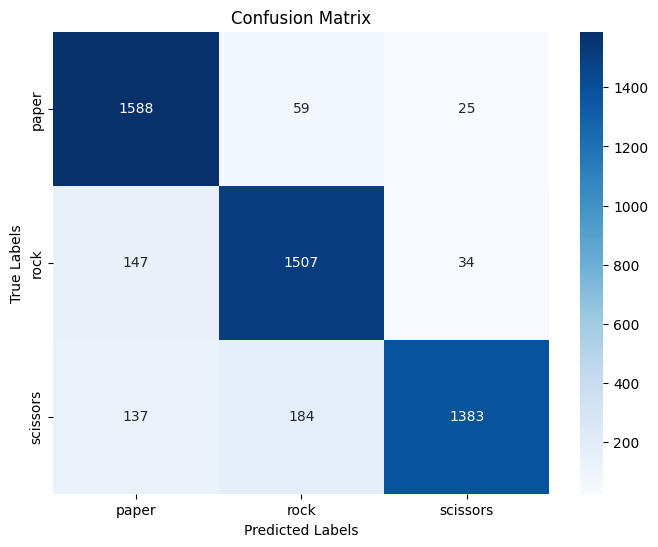

In [43]:
# Generate predictions
labels_predicted = model.predict(data_augmented)
labels_predicted_classes = np.argmax(labels_predicted, axis=1)
labels_augmented_classes = np.argmax(labels_augmented, axis=1)

# Classification report
class_report = classification_report(labels_augmented_classes, labels_predicted_classes, target_names=label_encoder.classes_)
print("\nClassification Report:\n", class_report)

# Confusion matrix
conf_matrix = confusion_matrix(labels_augmented_classes, labels_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [44]:
tflite_model = tflite_helper.convert_tflite_model(model)

tflite_helper.save_tflite_model(tflite_model, './training', 'model.tflite')

# print size of model
tflite_model_size = os.path.getsize('./training/model.tflite') / 1024  # KB
print(f"\nTFLite model size: {tflite_model_size:.2f} KB")

# funktion um das tflite modell in ein c array zu konvertieren(?)
def convert_to_c_array(file_path, output_file):
    with open(file_path, "rb") as f:
        data = f.read()
    
    data_length = len(data)
    
    with open(output_file, "w") as f:
        f.write(f"unsigned char model_tflite[] = {{\n")
        for i, byte in enumerate(data):
            f.write(f"0x{byte:02x}, ")
            if (i + 1) % 12 == 0:
                f.write("\n")
        f.write(f"\n}};\n\n")
        f.write(f"unsigned int model_tflite_len = {data_length};\n")

# Convert the TFLite model to a C array
convert_to_c_array('./training/model.tflite', './training/model.h')

INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmp3uxzbggw\assets


INFO:tensorflow:Assets written to: C:\Users\itsmi\AppData\Local\Temp\tmp3uxzbggw\assets


Saved artifact at 'C:\Users\itsmi\AppData\Local\Temp\tmp3uxzbggw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_224')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2640428633248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640428643984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640428635712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640428632016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640428641696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640428642576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640428632720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2640428641520: TensorSpec(shape=(), dtype=tf.resource, name=None)
Tflite model saved to %s ./training

TFLite model size: 41.42 KB



TFLite Classification Report:
               precision    recall  f1-score   support

       paper       0.85      0.95      0.90      1672
        rock       0.86      0.89      0.88      1688
    scissors       0.96      0.81      0.88      1704

    accuracy                           0.88      5064
   macro avg       0.89      0.88      0.88      5064
weighted avg       0.89      0.88      0.88      5064



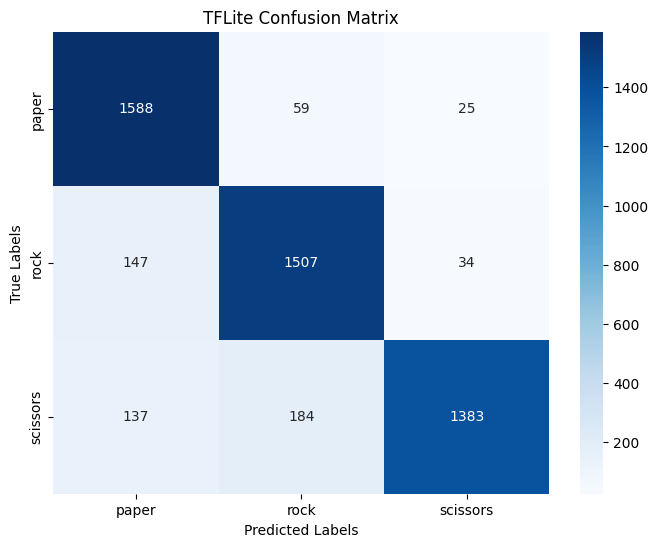

In [45]:
# Function to load the TFLite model and run inference
def run_tflite_inference(tflite_model_path, X_test):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    predictions = []
    for sample in X_test:
        # Prepare input tensor
        sample = np.expand_dims(sample, axis=0).astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], sample)

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0])

    return np.array(predictions)

# Run inference with TFLite model
tflite_model_path = './training/model.tflite'  # Path to your TFLite model
tflite_predictions = run_tflite_inference(tflite_model_path, data_augmented)

# Convert TFLite predictions to class indices
tflite_pred_classes = np.argmax(tflite_predictions, axis=1)
y_true_classes = np.argmax(labels_augmented, axis=1)

# Generate classification report
class_report = classification_report(y_true_classes, tflite_pred_classes, target_names=label_encoder.classes_)
print("\nTFLite Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, tflite_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('TFLite Confusion Matrix')
plt.show()

In [46]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path, header=None)
    data = df.values.flatten()
    return data[:64]

csv_file = './data/tof_capture.csv'

data = np.array([load_csv(csv_file)]).astype(np.float32)
# print(data)

data = np.reshape(data, (1, 64))

model = tf.keras.models.load_model('./training/model.keras')

np.set_printoptions(suppress=True)

# Vorhersage mit TensorFlow-Modell
prediction = model.predict(data)
print("Vorhersage (TensorFlow)\n", f'Paper: {prediction[0][0]}\n Rock: {prediction[0][1]}\n Scissors: {prediction[0][2]}\n\n')

tflite_model_path = './training/model.tflite'

# TensorFlow Lite Interpreter vorbereiten
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_tensor_index = interpreter.get_input_details()[0]['index']
output_tensor_index = interpreter.get_output_details()[0]['index']

interpreter.set_tensor(input_tensor_index, data)
interpreter.invoke()

lite_prediction = interpreter.get_tensor(output_tensor_index)
print("Vorhersage (TensorFlow Lite) \n", f'Paper: {lite_prediction[0][0]}\n Rock: {lite_prediction[0][1]}\n Scissors: {lite_prediction[0][2]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Vorhersage (TensorFlow)
 Paper: 0.00016887139645405114
 Rock: 0.0205618217587471
 Scissors: 0.9792692065238953


Vorhersage (TensorFlow Lite) 
 Paper: 0.00016887136735022068
 Rock: 0.020561937242746353
 Scissors: 0.9792690873146057


In [47]:

# Decode labels
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("Label Mapping:", label_map)

Label Mapping: {np.int64(0): np.str_('paper'), np.int64(1): np.str_('rock'), np.int64(2): np.str_('scissors')}
